In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import math

# Parameters

In [2]:
# Parameters 

#frequencies are in Hz, distance in m, power in W, gain in linear unit 

f_c=165*10**9
c=3*10**8
lambda_c=c/f_c
D=400*10**3
D_min=400*10**3
R_e=6378*10**3
D_max=np.sqrt(2*R_e*D+D**2)
B=0.5*10**9
A_DL=10**-4.903
P_DL=10**2.5
G_Rmax=10**(3.65)
G_DL=10**3.0
ki=10**-3.0
lambda_N=1.27*10**(-10)
lambda_B=3.18*10**-5
d_net=5*10**3
tau=10**(-20)
alpha_los=0.43
beta_los=10.31
D_ant=(lambda_c/np.pi)*np.sqrt(G_Rmax/0.6)
phi_m=(22*lambda_c/D_ant)*np.sqrt(5.5+5*np.log(0.36*D_ant/lambda_c)/np.log(10))


Beta_approx=np.array([-8.6237,0.4073,-0.7009,6.0676,-9.3461,5.7783])
Gamma_approx_DL=np.array([-3.5084,13.1974,-83.1330,142.8048,-112.7634,29.7639])
Gamma_approx_LOS=[1.7186,-2.2828,0.7688]
Gamma_approx_CL=[4.1693,2.4802,7.4796]
Gamma_approx_UL=[-1.2266,2.5653,-11.6678,23.7519,-21.8200,5.6038]


#integrale sur la zone qui affecte le satellite en "(R_e+D,0,0)"
I_F=2*np.pi*(1-(R_e**2/(R_e**2+R_e*D)))*(R_e**2)

#Other parameters
N=10**3

# Basic functions

In [3]:
#Basic functions

def theta(psi):
    norme=np.sqrt((R_e**2*np.sin(psi)**2+(R_e+D-R_e*np.cos(psi))**2))
    return np.arcsin((2*R_e*D+D**2-norme**2)/(2*norme*R_e))

def phi(psi):
    norme=np.sqrt((R_e**2*np.sin(psi)**2+(R_e+D-R_e*np.cos(psi))**2))
    return (180/np.pi)*np.arccos((R_e+D-R_e*np.cos(psi))/norme)

def d(ti):
    return np.sqrt(R_e**2*np.sin(ti)**2+2*R_e*D+D**2)-R_e*np.sin(ti)  

def pathloss(ti):
    s=0
    for i in range(len(Beta_approx)):
        s+=Beta_approx[i]*((d(ti)-D_min)/(D_max-D_min))**i
    return (c/(4*np.pi*f_c))**2*(d(ti)**(-2))*np.exp(-d(ti)*np.exp(s)*np.log(10)/10)

def p_DLs(ti):
    s=0
    for i in range(len(Gamma_approx_DL)):
        s+=(ti**i)*Gamma_approx_DL[i]
    return np.exp(s)

def p_UL(ti):
    s=0
    for i in range(len(Gamma_approx_UL)):
        s+=(ti**i)*Gamma_approx_UL[i]
    return np.exp(s)

def p_LOS(ti):
    s=0
    for i in range(len(Gamma_approx_LOS)):
        s+=(ti**i)*Gamma_approx_LOS[i]
    return np.exp(-s)

def g(ti):
    return np.exp(-Gamma_approx_CL[0]*np.exp(-ti*Gamma_approx_CL[1])+Gamma_approx_CL[2])
    

def kappa(lambda_B,d_net):
    return 2*np.pi*lambda_B*R_e*(R_e-np.sqrt(R_e**2-d_net**2))

def G_Rf(ti,G_Rmax): 
    if ti<=phi_m:
        return G_Rmax*10**(-1.8*10**(-4)*(D_ant*ti/lambda_c)**2)
    elif phi_m<=ti<=69:
        return np.max((G_Rmax*10**(-1.8*10**(-4)*(D_ant*ti/lambda_c)**2),10**(3.3)*(D_ant/lambda_c)**(-0.5)*ti**(-2.5)))
    else:
        return 10**(-1.3)*(D_ant/lambda_c)**(-0.5)

def condition(psi): #check whether psi is in Gamma
    return R_e**2 -R_e*np.cos(psi)*(R_e+D) <= 0


# Markov Bound

In [4]:
# MARKOV Bound

def f(psi,G_DL,G_R): 
    if condition(psi):
        return (p_DLs(theta(psi))*G_DL+(1-p_DLs(theta(psi)))*ki*G_DL)*np.sin(psi)*pathloss(theta(psi))*G_Rf(phi(psi),G_R)
    else :
         return 0

def markov_colocated(P_DL,A_DL,alpha_los,beta_los,lambda_N,lambda_B,d_net,tau,G_R,G_DL):
    return 2*np.pi*R_e**2*kappa(lambda_B,d_net)*lambda_N*P_DL*A_DL*alpha_los*beta_los*quad(f,0,np.pi,args=(G_DL,G_R))[0]/tau

# Sampling X_tilda

In [5]:
# Sampling X_tilda with acceptation-reject technique

y0=(0,0,R_e+D)
num_points=N
num_samples=N
threshold=np.sqrt((R_e+D)**2-R_e**2)

def generate_uniform_sphere_points(num_points):
    theta = np.random.uniform(0, 2 * np.pi, num_points)
    cos_phi = np.random.uniform(-1, 1, num_points)
    phi = np.arccos(cos_phi)
    
    x = R_e * np.sin(phi) * np.cos(theta)
    y = R_e * np.sin(phi) * np.sin(theta)
    z = R_e * np.cos(phi)
    
    points = np.column_stack((x, y, z))
    return points

def is_in_F(point):
    return np.linalg.norm(point - y0) <= threshold

def sample_uniform_F(num_samples):
    threshold = np.sqrt((R_e + D)**2 - R_e**2)
    samples = []
    while len(samples) < num_samples:
        # Générer des points sur la sphère
        points = generate_uniform_sphere_points(num_samples)
        for point in points:
            # Vérifier si le point est dans F_y0
            if is_in_F(point):
                samples.append(point)
                if len(samples) == num_samples:
                    break
    return np.array(samples)


# Samples
samples = sample_uniform_F(num_samples)
x = samples[:, 0]
y = samples[:, 1]
z = samples[:, 2]
    
# Compute r (radius)
r = np.sqrt(x**2 + y**2 + z**2)
    
# Compute phi (polar angle) in radians which will be the argument of our basic functions
psi = np.arccos(z / r)
psi

array([0.12822617, 0.344341  , 0.34353571, 0.29107952, 0.13305683,
       0.08713246, 0.07476081, 0.34095484, 0.22466471, 0.1092077 ,
       0.22425175, 0.0371145 , 0.14830068, 0.23276945, 0.33260765,
       0.21490129, 0.2990555 , 0.08608016, 0.27076455, 0.33128066,
       0.26738113, 0.22172816, 0.145272  , 0.17819686, 0.2772974 ,
       0.27771939, 0.19094619, 0.23159547, 0.03813796, 0.33391907,
       0.09148304, 0.26540149, 0.260375  , 0.02833776, 0.32629386,
       0.29839592, 0.17705115, 0.32155249, 0.03965119, 0.26742345,
       0.23362518, 0.17086918, 0.29940566, 0.17541679, 0.09426058,
       0.22786362, 0.16341034, 0.33258128, 0.30463164, 0.27753466,
       0.25110827, 0.25514288, 0.27644821, 0.20226721, 0.32974357,
       0.21736055, 0.28634829, 0.12934047, 0.33863643, 0.33976446,
       0.33701307, 0.13352184, 0.28614251, 0.28524663, 0.2483732 ,
       0.14420845, 0.03805343, 0.20604415, 0.13828958, 0.27768651,
       0.15070736, 0.27312506, 0.31006382, 0.18979499, 0.31718

# Computing moments and exponential moments of Z(X_tilda) throught sampling

In [6]:
# Computing moments and exponential moments of Z(X_tilda) throught sampling

def moment_Z_vecto_bis(k, N, A_DL, P_DL, alpha_los, beta_los, G_R, G_DL, lambda_B, d_net):
        cst = A_DL * P_DL * alpha_los * beta_los
        P = np.random.poisson(kappa(lambda_B, d_net), N)
        res = 0
        
        for i in range(N):
            theta_psi = theta(psi[i])
            phi_psi = phi(psi[i])
            pathloss_theta = pathloss(theta_psi)
            G_Rf_phi = G_Rf(phi_psi, G_R)
            p_DLs_theta = p_DLs(theta_psi)
            B = np.random.binomial(1, p_DLs_theta, P[i])
            s = np.sum(pathloss_theta * G_Rf_phi * cst * G_DL * (1 + (B == 0) * (ki - 1)))
            res += s ** k
        
        return res / N 
    



def expo_moment_Z_vecto_bis(t,N,A_DL, P_DL, alpha_los, beta_los, G_R, G_DL, lambda_B, d_net):
    cst = A_DL * P_DL * alpha_los * beta_los
    P = np.random.poisson(kappa(lambda_B, d_net), N)
    res = 0
    
    for i in range(N):
        theta_psi = theta(psi[i])
        phi_psi = phi(psi[i])
        pathloss_theta = pathloss(theta_psi)
        G_Rf_phi = G_Rf(phi_psi, G_R)
        p_DLs_theta = p_DLs(theta_psi)
        B = np.random.binomial(1, p_DLs_theta, P[i])
        s = np.sum(pathloss_theta * G_Rf_phi * cst * G_DL * (1 + (B == 0) * (ki - 1)))
        res += np.exp(t*s)
    return res/ N 

# Chernoff Bound

In [7]:
#gamma plug in with sampling

def t_gamma(A_DL,P_DL,G_DL,G_R,alpha_los,beta_los,lambda_B,d_net,tau,lambda_N,N):## gamma fit
    moyenne=moment_Z_vecto_bis(1, N, A_DL, P_DL, alpha_los, beta_los, G_R, G_DL, lambda_B, d_net)
    variance=moment_Z_vecto_bis(2, N, A_DL, P_DL, alpha_los, beta_los, G_R, G_DL, lambda_B, d_net)-moyenne**2
    alpha=moyenne**2/variance
    beta=variance/moyenne
    return (1/beta)*(1-(beta*alpha*lambda_N*I_F/tau)**(1/(alpha+1)))

## Better result with numerical integration for t_gamma

In [8]:
#gamma plug without sampling

def int_moyenne(psi,G_R,G_DL):
    if condition(psi):
        return G_Rf(phi(psi),G_R)*pathloss(theta(psi))*(p_DLs(theta(psi))*G_DL+(1-p_DLs(theta(psi)))*ki*G_DL)*np.sin(psi)
    else:
        return 0

def moyenne(G_R,G_DL,lambda_B,d_net,A_DL,P_DL,alpha_los,beta_los):### Compute the mean with numerical integration
    return (2*np.pi*R_e**2*kappa(lambda_B,d_net)*A_DL*P_DL*alpha_los*beta_los/I_F)*quad(int_moyenne,0,np.pi,args=(G_R,G_DL))[0]


def var_intermediaire_HDLcst(psi,alpha_los,beta_los,G_DL):
    return (p_DLs(theta(psi))*G_DL**2+(1-p_DLs(theta(psi)))*(ki*G_DL)**2)-(p_DLs(theta(psi))*G_DL+(1-p_DLs(theta(psi)))*ki*G_DL)**2

def int_var_HDLcst(psi,alpha_los,beta_los,G_DL,G_R,lambda_B,d_net):
    if condition(psi):
        return np.sin(psi)*pathloss(theta(psi))**2*G_Rf(phi(psi),G_R)**2*(kappa(lambda_B,d_net)*var_intermediaire_HDLcst(psi,alpha_los,beta_los,G_DL)+kappa(lambda_B,d_net)*(kappa(lambda_B,d_net)+1)*(p_DLs(theta(psi))*G_DL+(1-p_DLs(theta(psi)))*ki*G_DL)**2)
    else:
        return 0 
    
def variance_HDLcst(G_R,G_DL,lambda_B,d_net,A_DL,P_DL,alpha_los,beta_los): ## Compute the variance with numerical integration
    return (2*np.pi*R_e**2*(alpha_los*beta_los)**2/I_F)*A_DL**2*P_DL**2*quad(int_var_HDLcst,0,np.pi,args=(alpha_los,beta_los,G_DL,G_R,lambda_B,d_net))[0]-moyenne(G_R,G_DL,lambda_B,d_net,A_DL,P_DL,alpha_los,beta_los)**2


def t_gamma_bis(A_DL,P_DL,G_DL,G_R,alpha_los,beta_los,lambda_B,d_net,tau,lambda_N):
    alpha=moyenne(G_R,G_DL,lambda_B,d_net,A_DL,P_DL,alpha_los,beta_los)**2/variance_HDLcst(G_R,G_DL,lambda_B,d_net,A_DL,P_DL,alpha_los,beta_los)
    beta=variance_HDLcst(G_R,G_DL,lambda_B,d_net,A_DL,P_DL,alpha_los,beta_los)/moyenne(G_R,G_DL,lambda_B,d_net,A_DL,P_DL,alpha_los,beta_los)
    return (1/beta)*(1-(beta*alpha*lambda_N*I_F/tau)**(1/(alpha+1)))

In [9]:
# Determine the range of t 

x=np.logspace(-22.1,-20.5,num=50)
T=np.log10(np.max([t_gamma_bis(A_DL,P_DL,G_DL,G_Rmax,alpha_los,beta_los,lambda_B,d_net,tau,lambda_N) for tau in x]))
T



22.105163466162754

In [10]:
# chernoff polynomial approx

def pol_approx_bis(t,N,N_0,A_DL,P_DL,alpha_los,beta_los,G_R,G_DL,lambda_B,d_net):
    s=1
    for i in range(1,N_0):
        temp=i*np.log(float(t))-np.log(math.factorial(i))+np.log(moment_Z_vecto_bis(i,N,A_DL,P_DL,alpha_los,beta_los,G_R,G_DL,lambda_B,d_net))
        s+=np.exp(temp)
    return s

def reste_bis(N,N_0,A_DL,P_DL,alpha_los,beta_los,G_R,G_DL,lambda_B,d_net):
    x=np.logspace(0,T,50)
    y=[expo_moment_Z_vecto_bis(t,N,A_DL, P_DL, alpha_los, beta_los, G_R, G_DL, lambda_B, d_net)-pol_approx_bis(t,N,N_0,A_DL,P_DL,alpha_los,beta_los,G_R,G_DL,lambda_B,d_net) for t in x]
    return np.max(y)

def chernoff_pol_approx_bis(t,epsilon,tau,lambda_N,N,N_0,A_DL,P_DL,alpha_los,beta_los,G_R,G_DL,lambda_B,d_net):
    p=pol_approx_bis(t,N,N_0,A_DL,P_DL,alpha_los,beta_los,G_R,G_DL,lambda_B,d_net)
    return np.exp(-t*tau+lambda_N*I_F*(epsilon+p-1))

In [11]:
#Determine N_0
reste_bis(N,14,A_DL,P_DL,alpha_los,beta_los,G_Rmax,G_DL,lambda_B,d_net)


6.553858780122823e-07

# Plots

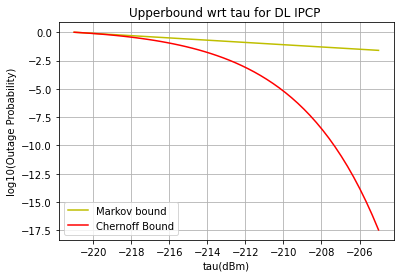

In [12]:
x=np.logspace(-22.1,-20.5,num=50)
x_dbm = 10 * np.log10(x)

y1=[markov_colocated(P_DL,A_DL,alpha_los,beta_los,lambda_N,lambda_B,d_net,tau,G_Rmax,G_DL) for tau in x]
epsilon=reste_bis(N,14,A_DL,P_DL,alpha_los,beta_los,G_Rmax,G_DL,lambda_B,d_net)
y2=[chernoff_pol_approx_bis(t_gamma_bis(A_DL,P_DL,G_DL,G_Rmax,alpha_los,beta_los,lambda_B,d_net,tau,lambda_N),epsilon,tau,lambda_N,N,14,A_DL,P_DL,alpha_los,beta_los,G_Rmax,G_DL,lambda_B,d_net) for tau in x]

plt.plot(x_dbm,np.log10(y1),color='y')
plt.plot(x_dbm,np.log10(y2),color='r')

plt.ylabel('log10(Outage Probability)')
plt.xlabel('tau(dBm)')
plt.title('Upperbound wrt tau for DL IPCP ')

plt.grid(True)
plt.legend(['Markov bound','Chernoff Bound'])
plt.show()